In [70]:
%%HTML
<style>
	@import url('https://fonts.googleapis.com/css2?family=JetBrains+Mono&display=swap');

	body {
		font-family: 'JetBrains Mono', -apple-system, BlinkMacSystemFont, 'Segoe WPC', 'Segoe UI', system-ui, 'Ubuntu', 'Droid Sans', sans-serif;
		line-height: 1.67;
	}
</style>

# Dynamic Periodic ETC for LPV Models under Saturation

_**[Event-based Control](https://github.com/andel-vitorio/event-based-control.git)**_

_by Andevaldo da Encarnação Vitório ([andevaldo.vitorio@icomp.ufam.edu.br](mailto:andevaldo.vitorio@icomp.ufam.edu.br)), last updated: April 20, 2025_

<!-- This notebook presents the implementation of the mathematical modeling and controller for a DC microgrid, represented by a buck converter with a CPL (Constant Power Load). The buck converter is a power conversion device that steps down a high DC voltage to a lower one. The CPL is a load that demands constant power regardless of variations in input voltage.

For the implementation, Python libraries such as Control, NumPy, and Matplotlib will be used. During implementation, the nonlinear system, shifted nonlinear system, and linearized system, all derived from the mathematical modeling, will be explored. -->

<!-- Detailed mathematical modeling can be found in the separate document titled ["Mathematical Modeling of a Microgrid"](../docs/Mathematical%20Modeling%20of%20a%20Microgrid.md), located in the `docs` directory.  -->

## 1. Importing Libraries

In [71]:
# Import modules for HTML display in the notebook and enable inline mode for Matplotlib
from IPython.display import display, HTML, Math, Latex
from IPython.core.magic import register_cell_magic
from typing import Callable, Optional, Union, Dict
  
%matplotlib inline

# Import common libraries for data manipulation, optimization, and control
import pandas as pd  # type: ignore
import cvxpy as cp  # type: ignore
from matplotlib.ticker import FuncFormatter, MultipleLocator  # type: ignore
from control.matlab import *  # type: ignore
import control.optimal as opt  # type: ignore
import control as ct  # type: ignore
import matplotlib.pyplot as plt  # type: ignore
import numpy as np
import matplotlib as mpl  # type: ignore
from matplotlib.patches import FancyArrowPatch # type: ignore
from scipy.integrate import quad # type: ignore
import importlib
import itertools
import csv
import concurrent.futures
from scipy.spatial import ConvexHull
import os
import json
from scipy.interpolate import interp1d

from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

utils_path = os.path.abspath(os.path.join("..", "Utils"))
if utils_path not in sys.path:
    sys.path.append(utils_path)

# Import utility functions from custom modules
import Tex as tex
import Graphs as gph
import Signal as sgn
import Numeric as nm

importlib.reload(tex)
importlib.reload(gph)
importlib.reload(sgn)
importlib.reload(nm)

# Set the use of feedback standards for the control package
ct.use_fbs_defaults()

# Attempt to configure LaTeX for text rendering, otherwise use default Matplotlib fonts
gph.use_latex()

# Set the resolution of figures generated by Matplotlib
mpl.rcParams['figure.dpi'] = 100

@register_cell_magic
def skip(line, cell):
  return

LaTeX has been enabled for text rendering.


## 2. LPV Model

In [72]:
import numpy as np
import control as ct  # assuming control is being used for `nlsys`


def get_A(p, params):
  OP = params['op']

  rC = p[0]

  A11 = - (params['rL'] / params['L'])
  A12 = - (1. / params['L'])
  A21 = 1. / params['C']
  A22 = (1. / params['C']) * (OP['Pcpl'] /
                              (OP['vC'] ** 2) - 1. / rC)

  return np.array([[A11, A12],
                   [A21, A22]])


def get_B(p, params):
  vIn = p[1]
  B11 = vIn / params['L']
  B21 = 0.
  return np.array([[B11],
                   [B21]])


def get_C(p):
  """
  Computes the C matrix for the system. In this case, it's fixed.

  Parameters
  ----------
  p : list or array
      The parameter values (not used here, kept for consistency).

  Returns
  -------
  np.ndarray
      The C matrix for the system.
  """
  return np.array([[0.0, 1.0]])


def plant_dynamics(time, x, inputs, params):
  """
  Updates the plant state based on the current time, states, inputs, and parameters.

  Parameters
  ----------
  time : float
      The current time (not used in this version).
  states : np.ndarray
      The current states of the system.
  inputs : np.ndarray
      The current inputs to the system.
  params : dict
      The parameters, including amounts of states, parameters, and inputs.

  Returns
  -------
  np.ndarray
      The time derivative of the states (x_dot).
  """
  # Extracting the number of inputs and parameters
  n_u = params['amounts']['u']
  n_p = params['amounts']['p']

  # Splitting inputs into u (control inputs) and p (parameters)
  _u = inputs[0:n_u][:]
  _p = inputs[n_u:n_u + n_p]

  # Getting the system matrices A and B
  A = get_A(_p, params)
  B = get_B(_p, params)

  # Computing the time derivative of the states (x_dot)
  x_dot = A @ x + B @ _u.reshape(1, -1)

  return x_dot


def plant_output(t, x, u, params):
  return x

## Predefinição da Simulação

In [73]:
def create_params(V_IN, RL, RC, L, C, PCPL_OP, VC_OP):
  """
  Create a dictionary of parameters for the system model.

  Parameters:
                  V_IN (float): Input voltage.
                  RL (float): Resistance of the inductor.
                  RC (float): Resistance of the capacitor.
                  L (float): Inductance.
                  C (float): Capacitance.
                  PCPL_OP (float): Operating power of the CPL.
                  VC_OP (float): Operating voltage of the capacitor.

  Returns:
                  dict: Dictionary of system parameters.

  """
  # Calculate the operating point (OP) values for inductor current and duty cycle
  IL_OP = (VC_OP / RC) + PCPL_OP / VC_OP
  D_OP = (RL * IL_OP) / V_IN + VC_OP / V_IN

  # Create the dictionary of parameters
  params = {
      "Vin": V_IN,
      "rL": RL,
      "rC": RC,
      "L": L,
      "C": C,
      "op": {"Pcpl": PCPL_OP, "vC": VC_OP, "iL": IL_OP, "d": D_OP},
  }

  return params

{'Vin': 15, 'rL': 0.2, 'rC': 6, 'L': 0.001, 'C': 0.0022, 'op': {'Pcpl': 17, 'vC': 5, 'iL': 4.233333333333333, 'd': 0.3897777777777778}, 'amounts': {'x': 2, 'p': 2, 'u': 1}}
[ 6.34169453 18.30756508]


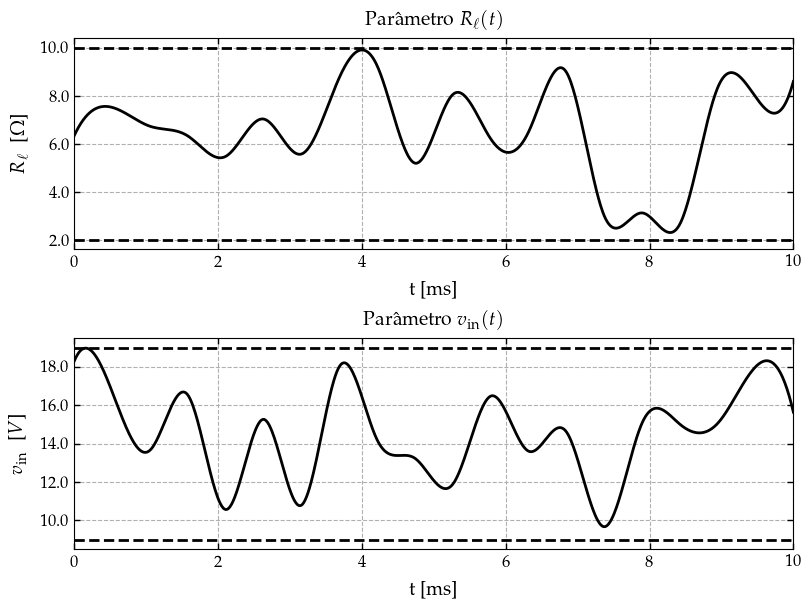

In [74]:
%matplotlib inline

simulation_step = 1e-5
simulation_time = 0.01
timepts = np.arange(0, simulation_time + simulation_step, simulation_step)

# Entrada para simulação em malha aberta
u = np.zeros((len(timepts), 1))

ρ_bounds = np.array([[2.0, 10.0],
                     [9.0, 19.0]])
x_bounds = [(-5, 5.), (-5., 5.)]

np.random.seed(0)

# Pontos de controle esparsos
segment_count = 20
ctrl_times = np.linspace(timepts[0], timepts[-1], segment_count)

# Geração dos valores base com limites definidos
rc_ctrl_values = np.random.uniform(2.5, 9.5, size=segment_count)
vin_ctrl_values = np.random.uniform(9.5, 18.5, size=segment_count)

# Interpolação suave (cúbica) entre os valores
rc_interp = interp1d(ctrl_times, rc_ctrl_values, kind='cubic')
vin_interp = interp1d(ctrl_times, vin_ctrl_values, kind='cubic')

# Geração dos sinais finais
Rc = rc_interp(timepts).reshape(-1, 1)
vIn = vin_interp(timepts).reshape(-1, 1)

amounts = {
    "amounts": {'x': 2, 'p': 2, 'u': 1}
}

params = create_params(
    V_IN=15, RL=.2, RC=6, L=1e-3,
    C=2.2e-3, PCPL_OP=17, VC_OP=5
)
params.update(amounts)
print(params)

u_bar = [min(1 - params['op']['d'], params['op']['d'])]
ρ = np.hstack([Rc, vIn])
print(ρ[0])

# Plotagem dos parâmetros
fig = plt.figure(figsize=(8, 6), layout='constrained')
axs = fig.subplot_mosaic([["Rc"], ["vIn"]])

timepts_multiplier = 1e3

cfg = {
  'style': { 'color': 'black', },
  'axis': { 'title_pad': 10, 'y_digits': 1, 'x_digits': 0,
            'x_label_fontsize': 14,
            'y_label_fontsize': 14,
            'tick_fontsize': 14,},
  'limits': { 'x_min': 0., 'x_max': simulation_time * 1e3,}
}

axs['Rc'].hlines([ρ_bounds[0][0], ρ_bounds[0][1]], 
                 0, simulation_time * timepts_multiplier, colors='black', linestyles='--', label='', linewidths=2.)

axs['vIn'].hlines([ρ_bounds[1][0], ρ_bounds[1][1]], 
                  0, simulation_time * timepts_multiplier, colors='black', linestyles='--', label='', linewidths=2.)

gph.plot(
    axs['Rc'],
    [t * timepts_multiplier for t in timepts], Rc,
    xlabel='t [ms]', ylabel='$R_{\\ell}\\;$ [$\\Omega$]',
    title='Parâmetro $R_{\\ell}(t)$',
    plot_cfg=cfg
)

gph.plot(
    axs['vIn'],
    [t * timepts_multiplier for t in timepts], vIn,
    xlabel='t [ms]', ylabel='$v_{\\rm in}\\;$ [$V$]',
    title='Parâmetro $v_{\\rm in}(t)$',
    plot_cfg=cfg
)

## Simulação da Planta em Malha Aberta

In [75]:
def openloop_simulation(x0, T_s):
  N = len(timepts)
  nx = x0.shape[0]

  x = np.zeros((nx, N + 1, 1))
  x[:, 0, :] = x0
  y = []

  for k in range(N):
    t = k * T_s

    util = np.hstack((u[k].reshape(1, -1),
                      ρ[k].reshape(1, -1)))[0]

    # Saída da planta
    y_k = plant_output(t, x[:, k, :], util, params)

    # Atualização dos estados para o próximo passo (k+1)
    if k < N - 1:
      x[:, k + 1, :] = nm.rk5_step(plant_dynamics, t,
                                   x[:, k, :], util, T_s, params)

    # Armazena controle e saída em k
    y.append(y_k)

  return y

In [76]:
x0 = np.array([[2.5], [2.5]])
y = openloop_simulation(x0, simulation_step)

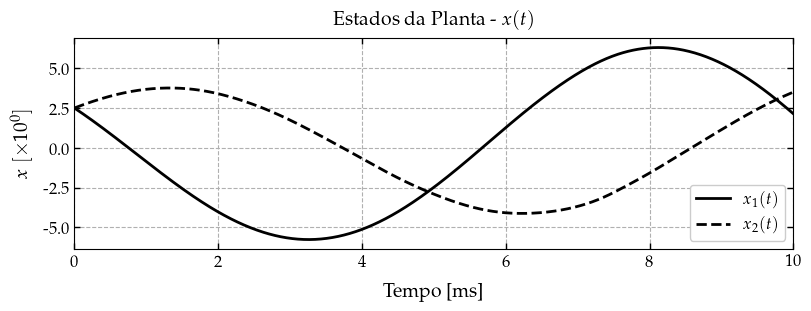

In [77]:
fig = plt.figure(figsize=(8, 3), layout='constrained')
axs = fig.subplot_mosaic([["x"]])

x_norm = np.array([np.linalg.norm(y_k) for y_k in y])

timepts_multiplier = 1e3

gph.plot(
    axs['x'], [t * timepts_multiplier for t in timepts],
    [v[0] for v in y],
    xlabel='Tempo [ms]', label='$x_1(t)$',
    plot_cfg={**cfg, 'style': {'color': 'black'}})

gph.plot(
    axs['x'], [t * timepts_multiplier for t in timepts],
    [v[1] for v in y],
    xlabel='Tempo [ms]', ylabel=r'$x$ $[\times 10^{0}]$',
    title='Estados da Planta - $x(t)$', label='$x_2(t)$',
    plot_cfg={**cfg, 'style': {'color': 'black', 'linestyle': '--'}})

In [78]:
def He(M): return M + M.T


def get_parameter(h, λ, ε, eps=1e-6):

  n_u = params['amounts']['u']
  n_p = params['amounts']['p']
  n_x = params['amounts']['x']

  Bnp = list(itertools.product([0, 1], repeat=n_p))
  Onx = np.zeros((n_x, n_x))
  O2nx = np.zeros((2 * n_x, 2 * n_x))

  aq = nm.get_vertices(x_bounds)

  A = {}
  B = {}

  for i in Bnp:
    pi = [ρ_bounds[idx][i[idx]] for idx in range(n_p)]
    A[i] = cp.Parameter((n_x, n_x), name=f'A[{i}]',
                        value=get_A(pi, params))
    B[i] = cp.Parameter((n_x, n_u), name=f'B[{i}]',
                        value=get_B(pi, params))

  e = nm.get_e(7 * [n_x] + [n_u])
  for i in range(1, 9):
    e[i] = cp.Parameter(e[i].shape, value=e[i], name=f"e{i}")

  Ptil = cp.Variable((n_x, n_x), PSD=True)
  Stil = cp.Variable((n_x, n_x), PSD=True)
  Mtil = cp.Variable((n_x, n_x), PSD=True)

  Pcal = cp.bmat([[Ptil,   Mtil],
                  [Mtil.T, Stil]])

  constraints = []

  Ktil = {}
  Lcal = {}
  ℵ = {}

  for i in Bnp:
    Ktil[i] = cp.Variable((n_u, n_x), name=f'K[{i}]')
    Lcal[i] = cp.Variable((n_u, n_x))
    ℵ[i] = cp.Variable((n_u, n_u), diag=True)
    constraints += [ℵ[i] >> 0]

  Qtil = cp.Variable((n_x, n_x), PSD=True)
  Rtil = cp.Variable((n_x, n_x), PSD=True)
  Ξtil = cp.Variable((n_x, n_x), PSD=True)
  Ψtil = cp.Variable((n_x, n_x), PSD=True)
  β = cp.Variable(pos=True)
  ρ = cp.Variable(pos=True)

  X = cp.Variable((n_x, n_x))
  Y1til = cp.Variable((2 * n_x, 2 * n_x))
  Y2til = cp.Variable((2 * n_x, 2 * n_x))

  Rcal = cp.bmat([[Rtil, Onx],
                  [Onx, 3. * Rtil]])

  N = e[1].T + λ * e[2].T + λ * e[3].T

  Π = cp.bmat([[e[1] - e[3]],
              [e[1] + e[3] - 2 * e[5]],
              [e[3] - e[4]],
              [e[3] + e[4] - 2 * e[6]]])

  κ1 = {}
  κ1['0'] = cp.bmat([[e[1]], [h * e[6]]])
  κ1['h'] = cp.bmat([[e[1]], [h * e[5]]])

  κ2 = cp.bmat([[e[2]], [e[1] - e[4]]])

  def get_Λ(i, j):
    Ytil = A[i] @ X @ e[1] - X @ e[2] + \
        B[i] @ Ktil[j] @ e[3] + B[i] @ Ktil[j] @ e[7] - \
        B[i] @ ℵ[j] @ e[8]

    Θtil = {}
    Θtil['0'] = 2 * κ1['0'].T @ Pcal @ κ2 + h * e[1].T @ Qtil @ e[1] - \
        h * e[4].T @ Qtil @ e[4] + (h ** 2) * e[2].T @ Rtil @ e[2] - \
        e[7].T @ Ξtil @ e[7] + He(N @ Ytil) - \
        2. * e[8].T @ ℵ[j] @ e[8] + 2. * \
        e[8].T @ Lcal[j] @ e[3] + 2. * e[8].T @ Lcal[j] @ e[7]

    Θtil['h'] = 2 * κ1['h'].T @ Pcal @ κ2 + h * e[1].T @ Qtil @ e[1] - \
        h * e[4].T @ Qtil @ e[4] + (h ** 2) * e[2].T @ Rtil @ e[2] - \
        e[7].T @ Ξtil @ e[7] + He(N @ Ytil) - \
        2. * e[8].T @ ℵ[j] @ e[8] + 2. * \
        e[8].T @ Lcal[j] @ e[3] + 2. * e[8].T @ Lcal[j] @ e[7]

    Φtil = {}

    Φtil1 = cp.bmat([[Rcal, O2nx],
                    [O2nx, Rcal]])
    Φtil2 = cp.bmat([[Rcal, Y2til], [Y2til.T, O2nx]])
    Φtil3 = cp.bmat([[O2nx, Y1til], [Y1til.T, Rcal]])

    Φtil['0'] = Φtil1 + Φtil2
    Φtil['h'] = Φtil1 + Φtil3

    Γ1_11 = Θtil['0'] - Π.T @ Φtil['0'] @ Π
    Γ1_12 = Π.T @ cp.bmat([[Y1til], [O2nx]])
    Γ1_13 = e[3].T @ X.T

    Γ1_21 = Γ1_12.T
    Γ1_22 = - Rcal
    Γ1_23 = np.zeros((2 * n_x, n_x))

    Γ1_31 = Γ1_13.T
    Γ1_32 = Γ1_23.T
    Γ1_33 = - Ψtil

    Γ1 = cp.bmat([[Γ1_11, Γ1_12, Γ1_13],
                  [Γ1_21, Γ1_22, Γ1_23],
                  [Γ1_31, Γ1_32, Γ1_33],])

    Γ2_11 = Θtil['h'] - Π.T @ Φtil['h'] @ Π
    Γ2_12 = Π.T @ cp.bmat([[O2nx], [Y2til.T]])
    Γ2_13 = e[3].T @ X.T

    Γ2_21 = Γ2_12.T
    Γ2_22 = - Rcal
    Γ2_23 = np.zeros((2 * n_x, n_x))

    Γ2_31 = Γ2_13.T
    Γ2_32 = Γ2_23.T
    Γ2_33 = - Ψtil

    Γ2 = cp.bmat([[Γ2_11, Γ2_12, Γ2_13],
                  [Γ2_21, Γ2_22, Γ2_23],
                  [Γ2_31, Γ2_32, Γ2_33],])

    return Γ1, Γ2

  binary_pairs = nm.binary_pairs(n_p)

  for pairs in binary_pairs:
    LMI_ST = {}
    LMI_ST['0'], LMI_ST['h'] = 0., 0.

    for pair in pairs:
      Λ = {}
      Λ['0'], Λ['h'] = get_Λ(pair[0], pair[1])
      LMI_ST['0'] += Λ['0']
      LMI_ST['h'] += Λ['h']

    constraints += [LMI_ST['0'] << -eps * np.eye(LMI_ST['0'].shape[0])]
    constraints += [LMI_ST['h'] << -eps * np.eye(LMI_ST['0'].shape[0])]

  for ell in range(n_u):
    for j in Bnp:
      LMISAT_11 = Ptil + (h ** 2) * Stil + h * (Qtil + Mtil + Mtil.T)
      LMISAT_12 = (Ktil[j][ell:ell+1] - Lcal[j][ell:ell+1]).T

      LMISAT_21 = LMISAT_12.T
      LMISAT_22 = β * (u_bar[ell] ** 2) * np.eye(1)

      LMISAT = cp.bmat([[LMISAT_11, LMISAT_12],
                        [LMISAT_21, LMISAT_22],])

      constraints += [LMISAT >> 0.]

  for i in range(4):
    LMI_INC_11 = β * np.eye(1)
    LMI_INC_12 = ρ * aq[i].T
    LMI_INC_21 = LMI_INC_12.T
    LMI_INC_22 = X.T + X - Ptil

    LMI_INC = cp.bmat([[LMI_INC_11,   LMI_INC_12],
                       [LMI_INC_21,  LMI_INC_22]])

    constraints += [LMI_INC >> 0.]

  constraints += [Pcal >> 0.]
  constraints += [(h ** 2) * Stil + h * (Qtil + Mtil + Mtil.T) << 0.]
  constraints += [ρ >= ε]

  obj = cp.Minimize(cp.trace(Ξtil + Ψtil) + β)
  prob = cp.Problem(obj, constraints)

  # Solve the problem using the MOSEK solver
  prob.solve(solver=cp.MOSEK, verbose=False, ignore_dpp=True)

  # Initialize variables to store results
  design_results = None

  # Display the results
  if prob.status not in ["infeasible", "unbounded"]:
    # print("Optimal value: %s\n" % prob.value)

    # matrix_utils.show_matrix(Ξtil.value, 'Ξtil')

    Xinv = np.linalg.inv(X.value)
    Ξ = Xinv.T @ Ξtil.value @ Xinv
    Ψ = np.linalg.inv(Ψtil.value)

    # matrix_utils.show_matrix(Xinv.T @ Ξtil.value)

    # matrix_utils.show_matrix(X.value, 'X')

    P = Xinv.T @ Ptil.value @ Xinv
    M = Xinv.T @ Mtil.value @ Xinv
    S = Xinv.T @ Stil.value @ Xinv
    Q = Xinv.T @ Qtil.value @ Xinv
    R = Xinv.T @ Rtil.value @ Xinv

    Pcal_ = np.block([[P, M], [M.T, S]])

    error = False

    if nm.matrix_definiteness(P) != 'pd' or \
       nm.matrix_definiteness(S) != 'pd' or \
       nm.matrix_definiteness(Pcal_) != 'pd':
      error = True

    if error == False:
      K = {}
      L = {}
      for i in Bnp:
        K[i] = Ktil[i].value @ Xinv
        L[i] = Lcal[i].value @ Xinv

      design_results = {
          'optimal_value': prob.value,
          'etm': {'Ξ': Ξ, 'Ψ': Ψ},
          'controller': {'K': K, 'L': L},
          'lyapunov': {'P': P, 'M': M, 'S': S, 'Q': Q, 'R': R},
          'bounds': {'β': β.value, 'ρ': ρ.value}
      }
  else:
    design_results = None

  return design_results

In [82]:
design_results = get_parameter(h=1e-4, λ=1e-4, ε=1e-2)

Ξ = Ψ = K = L = P = M = S = Q = R = γ = β = None

if design_results is not None:
  Ξ = design_results['etm']['Ξ']
  Ψ = design_results['etm']['Ψ']
  K = design_results['controller']['K']
  L = design_results['controller']['L']
  P = design_results['lyapunov']['P']
  M = design_results['lyapunov']['M']
  S = design_results['lyapunov']['S']
  Q = design_results['lyapunov']['Q']
  R = design_results['lyapunov']['R']
  # ρ = design_results['bounds']['ρ']
  β = design_results['bounds']['β']

  print('Resultados:')
  display(Math(rf'f^\star =' + tex.dec2tex(design_results['optimal_value'])))
  display(Math(rf'\beta =' + tex.dec2tex(β)))
  # display(Math(rf'\rho =' + tex.dec2tex(ρ)))
  display(Math(rf'x^\top(t) P x(t) \preceq' + tex.dec2tex(1. / β)))

  # display(Math(rf'P = ' + dp.mat2tex(P)))

  print('Matrizes de Acionamento:')
  display(Math(rf'\Xi = ' + tex.mat2tex(Ξ)))
  display(Math(rf'\Psi = ' + tex.mat2tex(Ψ)))

  print('Matrizes de Controle:')
  Bnp = list(itertools.product([0, 1], repeat=2))
  for i in Bnp:
    i_tex = "".join(map(str, i))
    display(Math(rf'K_{i_tex} = ' + tex.mat2tex(K[i])))
    display(Math(rf'G_{i_tex}= ' + tex.mat2tex(L[i])))
else:
  print('Problema não é factível!')

Resultados:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Matrizes de Acionamento:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Matrizes de Controle:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

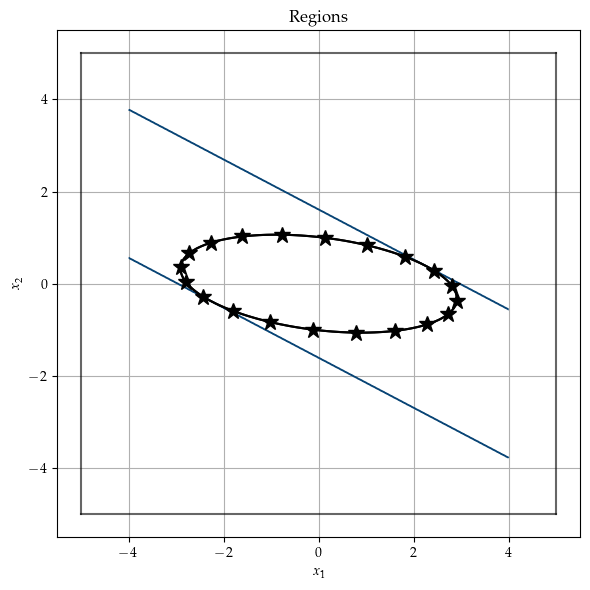

In [ ]:
%matplotlib inline

fig, ax = plt.subplots(1, 1, figsize=(6., 6.))

# Definindo intervalo de plotagem
x1_range = (-4, 4)
x2_range = (-4, 4)
num_points = 20
h = 1e-4

a_q = nm.get_vertices(x_bounds)

B2 = nm.binary_set(2)
u_max = u_bar[0]

x_vals = np.linspace(x1_range[0], x1_range[1], int(1e3))
y_vals = np.linspace(x2_range[0], x2_range[1], int(1e3))


X, Y = np.meshgrid(x_vals, y_vals)
points = np.vstack([X.ravel(), Y.ravel()]).T
Du_region = np.ones(X.shape, dtype=bool)
for b in B2:
  result = np.abs(points @ (K[b] - L[b]).T)
  Du_region &= (result.reshape(X.shape) <= u_bar[0])
ax.contour(X, Y, Du_region, colors='#084475', linewidths=1.27)


D_vertices = nm.get_polyhedral_set(a_q, x_bounds)['intersection_points']

if D_vertices.size > 0:
  try:
    hull = ConvexHull(D_vertices)
    for simplex in hull.simplices:
      ax.plot(D_vertices[simplex, 0], D_vertices[simplex, 1], 'k-', alpha=0.6)
  except:
    print("Unable to compute ConvexHull or plot the polyhedron edges.")

X0_list = nm.ellipsoid_boundary_points(P, (1. / β), num_points)
plt.plot(X0_list[0], X0_list[1], '*',
         linestyle='None', c='black', markersize=12)

D0 = nm.get_ellipsoid_boundary(P, (1. / β))
plt.plot(D0['x1_vals'], D0['x2_vals'], 
         'k-', label='Ellipsoid Boundary')

# Função V 
def compute_V(X1, X2, P, M, S, Q, h):
    V_values = np.zeros_like(X1)
    for i in range(X1.shape[0]):
        for j in range(X1.shape[1]):
            x = np.array([X1[i, j], X2[i, j]])
            ξ = np.hstack((x, h * x))
            Pcal = np.block([[P, M], [M.T, S]])
            V1 = ξ.T @ Pcal @ ξ

            integral_1 = h * x.T @ Q @ x
            integral_2 = ((h ** 3) / 2.) * x.T @ R @ x

            V2 = integral_1 + integral_2
            V_values[i, j] = V1 + V2
    return V_values

X1, X2, V_values, contour_data = nm.get_region_boundary(
    lambda X1, X2: compute_V(X1, X2, P, M, S, Q, h), 
    x1_range=x1_range, x2_range=x2_range, num_points=100
)

plt.contour(X1, X2, V_values, levels=[1. / β], 
            colors='black', linestyles='-')

# Ajustes finais de layout
ax.set_title("Regions")
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.grid(True)

# Exibir o gráfico
plt.tight_layout()

In [13]:
def closedloop_simulation(x0, η0, λ, θ, T_s):
  N = len(timepts)
  nx = x0.shape[0]

  x = np.zeros((nx, N + 1, 1))
  x[:, 0, :] = x0
  η = np.zeros((N + 1, 1))
  η[0, :] = η0

  xτ = x0.copy()

  y = []
  uc = []

  ρ_hat = ρ[0]
  x_hat = x0
  event_times = [0.]

  next_time_sampling = h

  def triggering_condition(η, x, ε, ρ):
    Tcal = x.T @ Ψ @ x - ε.T @ Ξ @ ε
    new_event = η + θ * Tcal[0][0] < 0
    return new_event

  def etm_dynamics(t, η, u, params):
    ε = x_hat - xτ
    Tcal = xτ.T @ Ψ @ xτ - ε.T @ Ξ @ ε
    η_dot = - λ * η + Tcal[0][0]
    return η_dot

  def control_signal():
    α0 = (ρ_bounds[0][1] - ρ_hat) / (ρ_bounds[0][1] - ρ_bounds[0][0])
    α1 = (ρ_bounds[1][1] - ρ_hat) / (ρ_bounds[1][1] - ρ_bounds[1][0])
    uc_k = α0 * K[(0, 0)] @ x_hat + (1. - α0) * K[(0, 1)] @ x_hat + \
        α1 * K[(1, 0)] @ x_hat + (1. - α1) * K[(1, 1)] @ x_hat
    return np.array([[sgn.sat(uc_k[0, 0], u_bar[0])]])

  for k in range(N):
    t = timepts[k]

    # Verificação da condição de acionamento
    if t >= next_time_sampling:
      next_time_sampling += h
      xτ = x[:, k, :]
      ε = x_hat - xτ
      new_event = triggering_condition(η[k], xτ, ε, ρ[k])
      if new_event:
        x_hat = xτ
        ρ_hat = ρ[k]
        event_times.append(t)

    # Cálculo do sinal de controle
    uc_k = control_signal()
    util = np.hstack((uc_k.reshape(1, -1),
                      ρ[k].reshape(1, -1)))[0]
    # Saída da planta
    y_k = plant_output(t, x[:, k, :], util, params)

    # Atualização dos estados para o próximo passo (k+1)
    if k < N - 1:
      x[:, k + 1, :] = nm.rk5_step(plant_dynamics, t,
                                   x[:, k, :], util, T_s, params)
      η[k + 1, :] = nm.rk5_step(etm_dynamics, t, η[k, :], None, T_s, None)

    # Armazena controle e saída em k
    uc.append(uc_k)
    y.append(y_k)

  return y, uc, η[:N], event_times

In [14]:
# Nome do arquivo de experimento
experiment_name = "Results/nb1/ClosedLoop_Results_n2.json"
λ = 1e-3
# Define se as simulações devem ser forçadas mesmo se o arquivo já existir
force_simulation = True
simulations_amount = 20

# Estrutura para armazenar os resultadosevent_times
results_clsim = {
    'inter-event-times': [],
    'control-signal': [],
    'trajectories': [],
    'eta': [],
}

# Função para converter arrays e listas aninhadas em estruturas serializáveis


def convert_to_serializable(obj):
  if isinstance(obj, np.ndarray):
    return obj.tolist()
  elif isinstance(obj, list):
    return [convert_to_serializable(item) for item in obj]
  elif isinstance(obj, dict):
    return {key: convert_to_serializable(val) for key, val in obj.items()}
  return obj

# Função para converter de volta para arrays


def convert_to_numpy(obj):
  return {
      'trajectories': [np.array(y_k) for y_k in obj['trajectories']],
      'control-signal': [np.array(u_k) for u_k in obj['control-signal']],
      'eta': [np.array(eta_k) for eta_k in obj['eta']],
      'inter-event-times': obj['inter-event-times'],
  }


# Verificar se o arquivo já existe
if os.path.exists(experiment_name) and not force_simulation:
  print(f"O arquivo {experiment_name} já existe. Carregando dados salvos.")
  with open(experiment_name, "r") as f:
    loaded = json.load(f)
    results_clsim = convert_to_numpy(loaded)
else:
  def get_trajectories(i):
    θ = (1. / λ) * (np.exp(λ * h) - 1.)
    h = 1e-4

    x0 = np.array([[X0_list[0][i]], [X0_list[1][i]]])
    η0 = np.array([[0.]])
    y, uc, η, event_times = closedloop_simulation(
        x0, η0, λ, θ, T_s=simulation_step)
    inter_event_times = np.diff(event_times).tolist()

    return {
        'trajectories': y,
        'eta': η,
        'control-signal': uc,
        'inter-event-times': inter_event_times
    }

  # Paralelismo com ProcessPoolExecutor
  with concurrent.futures.ProcessPoolExecutor() as executor:
    results = list(executor.map(get_trajectories,
                                range(simulations_amount)))

  # Atualizar estrutura de resultados
  for res in results:
    results_clsim['trajectories'].append(res['trajectories'])
    results_clsim['inter-event-times'].append(res['inter-event-times'])
    results_clsim['control-signal'].append(res['control-signal'])
    results_clsim['eta'].append(res['eta'])

  # Serializar e salvar
  results_serializable = convert_to_serializable(results_clsim)

  with open(experiment_name, "w") as f:
    json.dump(results_serializable, f, indent=2)

  print(f"Simulações concluídas. Resultados salvos em {experiment_name}.")

UnboundLocalError: cannot access local variable 'h' where it is not associated with a value

In [ ]:
B2 = nm.binary_set(2)
u_max = u_bar[0]

x_vals = np.linspace(-3.5, 3.5, 200)
y_vals = np.linspace(-3.5, 3.5, 200)

X, Y = np.meshgrid(x_vals, y_vals)
points = np.vstack([X.ravel(), Y.ravel()]).T

Du_region = np.ones(X.shape, dtype=bool)

for b in B2:
  K_b = K[b]
  G_b = L[b]
  K_minus_G = K_b - G_b
  result = np.abs(np.dot(points, K_minus_G.T))
  Du_region &= (result.reshape(X.shape) <= u_max)

In [ ]:
%matplotlib tk

x1_range = (-3.5, 3.5)
x2_range = (-3.5, 3.5)

trajectories = results_clsim['trajectories']

fig, ax = plt.subplots(1, 1, figsize=(6., 6.))
fig.canvas.manager.set_window_title(
    "Região de Estabilidade Externa/Estados Iniciais Admissíveis")

X1, X2, V_values, contour_data = nm.get_region_boundary(
    lambda X1, X2: compute_V(X1, X2, P, M, S, Q, h), 
    x1_range=x1_range, x2_range=x2_range, num_points=100
)

ax.contour(X1, X2, V_values, levels=[1. / β], 
            colors='black', linestyles='-')

ax.plot(X0_list[0], X0_list[1], '*',
         linestyle='None', c='black', markersize=10)


for y in trajectories:
  ax.plot([v[0] for v in y], [v[1] for v in y], 
          color='black', linestyle=':')

contour = ax.contour(X, Y, Du_region, 
                     colors='#084475', linewidths=2.)


ax.set_xlabel("$x_1$", fontsize=14)
ax.set_ylabel("$x_2$", fontsize=14, labelpad=0.)
ax.tick_params(axis='both', direction='in', length=4, width=1,
               colors='black', top=True, right=True, labelsize=14)
ax.grid(True, linestyle='--', alpha=0.6)

# axins = inset_axes(ax, width="40%", height="40%", loc="upper right")
# # Ajustando os limites da área de zoom
# axins.set_xlim(-0.15, 0.15)
# axins.set_ylim(-0.2, 0.2)
# axins.tick_params(axis='both', direction='in', length=4, width=1,
#                colors='black', top=True, right=True, labelsize=14)
# axins.grid(True, linestyle='--', alpha=0.6)
# mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="gray")

# for y in trajectories:
#   axins.plot([v[0] for v in y], [v[1] for v in y], 
#           color='black', linestyle=':')
# axins.plot(X0_list[0], X0_list[1], '*',
#          linestyle='None', c='black', markersize=10)
# axins.contour(X1, X2, V_values, levels=[1. / β], 
#             colors='black', linestyles='-')
# axins.contour(X, Y, valid_points, 
#                      colors='#084475', linewidths=1.)

elements = [
    ('line', {'color': '#084475', 'linestyle': '-', 'linewidth': 2}),
    ('line', {'color': 'black', 'linestyle': '-', 'linewidth': 2.}),
    ('line', {'color': 'black', 'linestyle': ':', 'linewidth': 2.}),
    ('marker', {'marker': '*', 'color': 'black', 'markersize': 10})
]

labels = ['${\\cal D}_u$', '${\\cal D}_x$', 
          'Trajetórias', 'Pontos Iniciais']

gph.create_custom_legend(ax, elements, labels)

plt.tight_layout()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<>:61: SyntaxWarning: invalid escape sequence '\;'
<>:73: SyntaxWarning: invalid escape sequence '\;'
<>:61: SyntaxWarning: invalid escape sequence '\;'
<>:73: SyntaxWarning: invalid escape sequence '\;'
/tmp/ipykernel_7905/3643347155.py:61: SyntaxWarning: invalid escape sequence '\;'
  xlabel='t [ms]', ylabel='sat$(u(t))\;$ [$\\times 10^{-1}$]',
/tmp/ipykernel_7905/3643347155.py:73: SyntaxWarning: invalid escape sequence '\;'
  xlabel='t [ms]', ylabel='$t_{k+1} - t_k\;$ [$10^{-4} s$]',


Estado Inicial:  [-2.80323632  0.04508783]
Número de Eventos Acionados:  43
Menor IET Obtido:  9.000000000000024e-05
Máximo IET Obtido:  0.0010099999999999996
Média do Intervalos de Tempo entre Eventos:  0.00022558139534883723


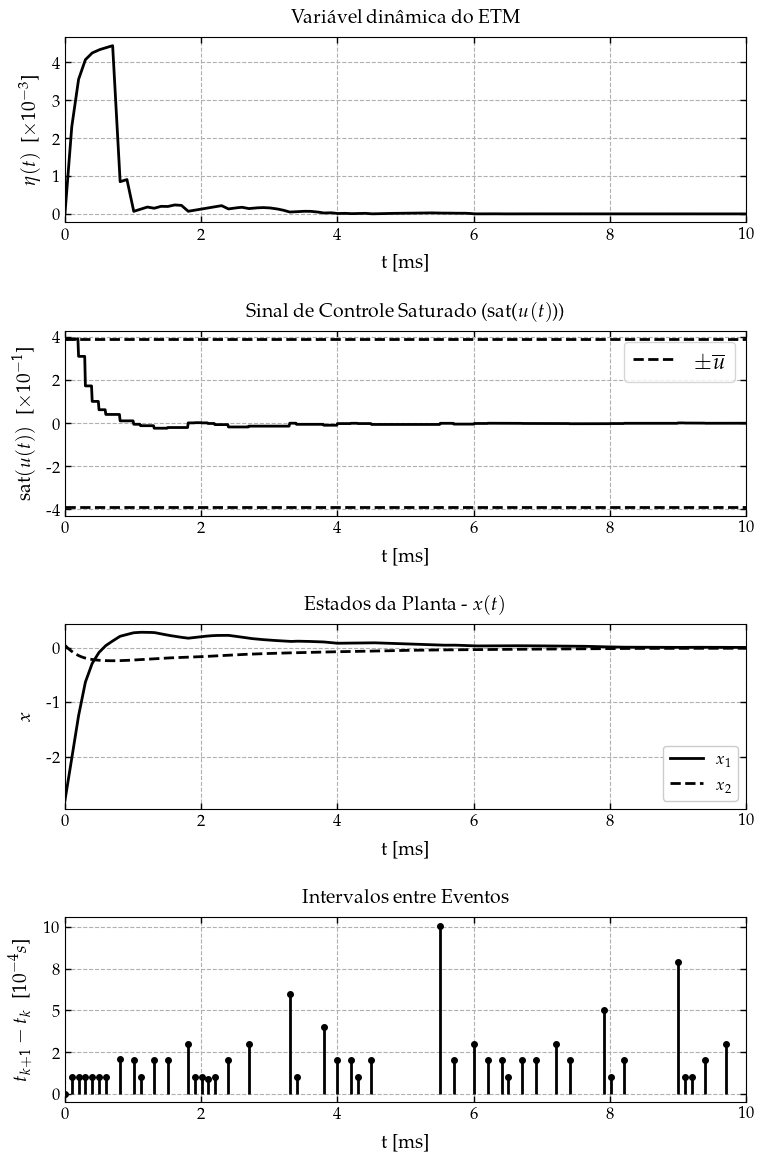

In [ ]:
%matplotlib inline

fig, axs = plt.subplot_mosaic([['η'], ['sat'], ['x'], ['iet']], 
                              figsize=(8, 12))

cfg = {
  'style': { 'color': 'black', },
  'axis': { 'title_pad': 10, 'y_digits': 0, 'x_digits': 0,
            'x_label_fontsize': 14,
            'y_label_fontsize': 14,
            'tick_fontsize': 14,},
  'limits': { 'x_min': 0., 'x_max': simulation_time * 1e3,}
}

simulation_index = 19
η = results_clsim['eta'][simulation_index]
inter_event_times = results_clsim['inter-event-times'][simulation_index]
uc = results_clsim['control-signal'][simulation_index]
y = results_clsim['trajectories'][simulation_index]
event_times = np.cumsum(inter_event_times)

print("Estado Inicial: ", y[0].reshape(-1))
print("Número de Eventos Acionados: ", len(inter_event_times))
print("Menor IET Obtido: ", min(inter_event_times))
print("Máximo IET Obtido: ", max(inter_event_times))
print("Média do Intervalos de Tempo entre Eventos: ", np.mean(
      inter_event_times) )

gph.plot(
    axs['η'], [et * 1e3 for et in timepts], 
    [v * 1e3 for v in η],
    xlabel='t [ms]', ylabel='$\\eta(t)\\,$ [$\\times 10^{-3}$]',
    title='Variável dinâmica do ETM',
    plot_cfg=cfg)

if inter_event_times[0] != 0.0:
  inter_event_times = np.insert(inter_event_times, 0, 0.0)
if event_times[0] != 0.0:
  event_times = np.insert(event_times, 0, 0.0)


axs['sat'].hlines([u_bar[0] * 1e1, -u_bar[0] * 1e1], 0, simulation_time * 1e3, colors='black', linestyles='--', label='$\\pm \\overline{u}$', linewidths=2.)
axs['sat'].legend(prop={'size': 16})


# Plot sinal de saída
gph.plot(
    axs['x'], [et * 1e3 for et in timepts], [v[0] for v in y],
    xlabel='t [ms]', label='$x_1$',
    plot_cfg={**cfg, 'style': {'color': 'black'}})

gph.plot(
    axs['x'], [et * 1e3 for et in timepts], [v[1] for v in y],
    xlabel='t [ms]', ylabel=r'$x$',
    title='Estados da Planta - $x(t)$', label='$x_2$',
    plot_cfg={**cfg, 'style': {'color': 'black', 'linestyle': '--'}})

gph.plot(
    axs['sat'], [et * 1e3 for et in timepts],
    [float(v[0, 0]) * 1e1 for v in uc],
    xlabel='t [ms]', ylabel='sat$(u(t))\;$ [$\\times 10^{-1}$]',
    title='Sinal de Controle Saturado (sat($u(t)$))', plot_cfg=cfg)

# Plot dos IETs
if len(inter_event_times) > 0:
    stem_cfg = cfg.copy()
    stem_cfg['axis']['y_digits'] = 0

    gph.stem(
      axs['iet'], [et for et in event_times * 1e3],
      [et * 1e4 for et in inter_event_times],
      stem_cfg={**stem_cfg, 'style': {'color': 'black'}},
      xlabel='t [ms]', ylabel='$t_{k+1} - t_k\;$ [$10^{-4} s$]',
      title='Intervalos entre Eventos')


else:
    axs['iet'].text(0.5, 0.5, 'No triggered events',
                    ha='center', va='center', fontsize=14,
                    transform=axs['iet'].transAxes)
    axs['iet'].set_title('Inter-event Times')
    axs['iet'].set_xlabel('t [ms]')
    axs['iet'].set_ylabel('$t_{k+1} - t_k$ [$ms$]')
    axs['iet'].set_xlim([0, simulation_time])
    axs['iet'].set_ylim([0, 1])  # valor simbólico
    axs['iet'].grid(False)

plt.tight_layout(pad=2.)

In [ ]:
import concurrent.futures
import numpy as np
import control as ct
import os
import json
import itertools
import pandas as pd

# Nome do arquivo de experimento
experiment_name = "CLSim_ETMParameters_23fev2025_Exp1.json"

# Definição dos parâmetros
upsilon_values = [1e0, 1e2, 1e4]
theta_values = [1e-2, 1e-1, 1e0, 1e1, 1e2]

# Gerar combinações de upsilon e theta
upsilon_theta_pairs = list(itertools.product(upsilon_values, theta_values))

# Estrutura para armazenar os resultados
results_clsim_etm = {
    'upsilon_theta': [],
    'inter-event-times': [],
    'experiment_parameters': {
        'upsilon_values': upsilon_values,
        'theta_values': theta_values,
        'upsilon_theta_pairs': upsilon_theta_pairs,
    }
}

# Função para obter trajetórias


def get_trajectories(args):
  upsilon, theta = args

  x0 = np.array([[X0_list[0][19]], [X0_list[1][19]]])
  η0 = np.array([[0.]])
  y, uc, η, event_times = closedloop_simulation(
      x0, η0, upsilon, theta, T_s=simulation_step)
  inter_event_times = np.diff(event_times).tolist()

  avg_inter_event_time = np.mean(
      inter_event_times) if inter_event_times else 0

  return {'upsilon': upsilon, 'theta': theta,
          'avg_inter_event_time': avg_inter_event_time}


# Verificar se o arquivo já existe
if os.path.exists(experiment_name):
  with open(experiment_name, "r") as f:
    results_clsim_etm = json.load(f)
else:
  # Executar experimentos se o arquivo não existir
  with concurrent.futures.ProcessPoolExecutor() as executor:
    results = list(executor.map(get_trajectories, upsilon_theta_pairs))

  # Atualizar estrutura de resultados
  for res in results:
    results_clsim_etm['upsilon_theta'].append(
        (res['upsilon'], res['theta']))
    results_clsim_etm['inter-event-times'].append(
        res['avg_inter_event_time'])

  # Salvar resultados em um arquivo JSON
  with open(experiment_name, "w") as f:
    json.dump(results_clsim_etm, f, indent=4)

# print(results_clsim_etm)

# Criar DataFrame com colunas separadas para upsilon e theta
df = pd.DataFrame({
    'upsilon_theta': results_clsim_etm['upsilon_theta'],
    'inter-event-times': results_clsim_etm['inter-event-times']
})

# Separar as colunas de upsilon e theta
df[['upsilon', 'theta']] = pd.DataFrame(
    df['upsilon_theta'].tolist(), index=df.index)

# Criar tabela pivotada com upsilon nas colunas e theta nas linhas
pivot_df = df.pivot(index='theta', columns='upsilon',
                    values='inter-event-times')

# Exibir a tabela
print(pivot_df)

upsilon   1.0       100.0     10000.0
theta                                
0.01     0.612857  0.202609  0.199167
0.10     0.660000  0.188000  0.202917
1.00     0.566667  0.199167  0.202917
10.00    0.671429  0.202917  0.202917
100.00   0.446250  0.202917  0.202917
